In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import os
import matplotlib.pyplot as plt

In [18]:
tf.random.set_seed(23)

In [19]:
# Cargar y Preprocesar el Dataset
dataset_dir = "../datasets"
image_size = (224, 224)  # MobileNetV2 espera imágenes de 224x224
batch_size = 16

train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(dataset_dir, "train"),
    labels="inferred",
    label_mode="int",
    image_size=image_size,
    interpolation="bicubic",
    batch_size=batch_size,
    shuffle=True,
    follow_links=False,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(dataset_dir, "val"),
    labels="inferred",
    label_mode="int",
    image_size=image_size,
    interpolation="bicubic",
    batch_size=batch_size,
    shuffle=False,
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(dataset_dir, "test"),
    labels="inferred",
    label_mode="int",
    image_size=image_size,
    interpolation="bicubic",
    batch_size=batch_size,
    shuffle=False,
)

# Obtener los nombres de las clases (ordenados por el directorio)
class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Clases detectadas: {class_names}")
print(f"Número de clases: {num_classes}")


Found 663 files belonging to 7 classes.
Found 82 files belonging to 7 classes.
Found 85 files belonging to 7 classes.
Clases detectadas: ['anaconda', 'capibara', 'mono-capuchino', 'picure', 'piranha', 'ranita-minera', 'tapir']
Número de clases: 7


In [20]:
# Configurar el aumento de datos (Data Augmentation)
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.1),
        # Puedes añadir más capas de aumento de datos aquí
    ],
    name="data_augmentation",
)

In [21]:
# Aplicar aumento solo al conjunto de entrenamiento
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

In [22]:
# Optimizar el rendimiento de la carga de datos
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [23]:
# Cargar MobileNetV2
base_model = tf.keras.applications.MobileNetV2(
    input_shape=image_size + (3,),
    include_top=False,
    weights='imagenet',
)

base_model.trainable = False  # No actualizar capas inferiores en las primeras épocas

In [24]:
inputs = keras.Input(shape=image_size + (3,))
x = inputs

# Construir modelo de fine-tuning
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)  # Capa de dropout para regularización
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = keras.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         8,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,266,951 (8.65 MB)

 Trainable params: 8,967 (35.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [25]:
# Definir el Early Stopping
early_stopping_callback = EarlyStopping(
    monitor="val_loss",
    patience=4,
    restore_best_weights=True,
    verbose=1,
)

In [26]:
epochs_initial = 10
print(f"\nEntrenando las capas superiores por {epochs_initial} épocas...")
history_initial = model.fit(
    train_ds,
    epochs=epochs_initial,
    validation_data=val_ds,
    callbacks=[early_stopping_callback],
)


Entrenando las capas superiores por 10 épocas...
Epoch 1/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 18s 342ms/step - accuracy: 0.2368 - loss: 2.1234 - val_accuracy: 0.2805 - val_loss: 1.7623
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 205ms/step - accuracy: 0.3932 - loss: 1.6709 - val_accuracy: 0.3537 - val_loss: 1.6054
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 193ms/step - accuracy: 0.4941 - loss: 1.4219 - val_accuracy: 0.4024 - val_loss: 1.5338
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 194ms/step - accuracy: 0.5055 - loss: 1.3361 - val_accuracy: 0.4268 - val_loss: 1.4993
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 193ms/step - accuracy: 0.5422 - loss: 1.2370 - val_accuracy: 0.4390 - val_loss: 1.4422
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 199ms/step - accuracy: 0.5941 - loss: 1.1584 - val_accuracy: 0.4512 - val_loss: 1.4305
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 202ms/step - accuracy: 0.6315 - loss: 1.0760 - val_accuracy: 0.4268 - val_loss: 1.3999
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 219ms/step -

In [27]:
base_model.trainable = True

# Congelar capas de Batch Normalization (BN)
# Es una práctica común dejar las capas de Batch Normalization congeladas durante el fine-tuning,
# ya que sus estadísticas pueden volverse inestables con tamaños de batch pequeños.
for layer in base_model.layers:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False

# Recompilar el modelo con un learning rate más bajo
model.compile(
    optimizer=keras.optimizers.Adam(
        learning_rate=1e-5
    ),  # Learning rate más bajo para fine-tuning
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         8,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,266,951 (8.65 MB)

 Trainable params: 2,198,727 (8.39 MB)

 Non-trainable params: 68,224 (266.50 KB)

In [28]:
epochs_fine_tune = 10  # Más épocas para el fine-tuning profundo
total_epochs = epochs_initial + epochs_fine_tune

print(
    f"\nContinuando el entrenamiento (fine-tuning profundo) por {epochs_fine_tune} épocas..."
)
history_fine_tune = model.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=history_initial.epoch[-1] + 1,
    validation_data=val_ds,
    callbacks=[early_stopping_callback],
)


Continuando el entrenamiento (fine-tuning profundo) por 10 épocas...
Epoch 11/20


42/42 ━━━━━━━━━━━━━━━━━━━━ 30s 494ms/step - accuracy: 0.6807 - loss: 0.9286 - val_accuracy: 0.5488 - val_loss: 1.3118
Epoch 12/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 20s 465ms/step - accuracy: 0.7201 - loss: 0.7387 - val_accuracy: 0.5244 - val_loss: 1.3521
Epoch 13/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 19s 448ms/step - accuracy: 0.7922 - loss: 0.6341 - val_accuracy: 0.5122 - val_loss: 1.4063
Epoch 14/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 19s 446ms/step - accuracy: 0.8356 - loss: 0.5426 - val_accuracy: 0.5366 - val_loss: 1.4567
Epoch 15/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 21s 511ms/step - accuracy: 0.8414 - loss: 0.5037 - val_accuracy: 0.5488 - val_loss: 1.3550
Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 11.


In [29]:
# --- 8. Evaluar el Modelo ---
loss, accuracy = model.evaluate(test_ds)
print(f"\nPrecisión en el conjunto de prueba: {accuracy * 100:.2f}%")


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step - accuracy: 0.4820 - loss: 1.5099

Precisión en el conjunto de prueba: 44.71%


In [30]:
# --- 9. Guardar el Modelo ---
model.save("mobilenet_fine_tuned_model.h5")

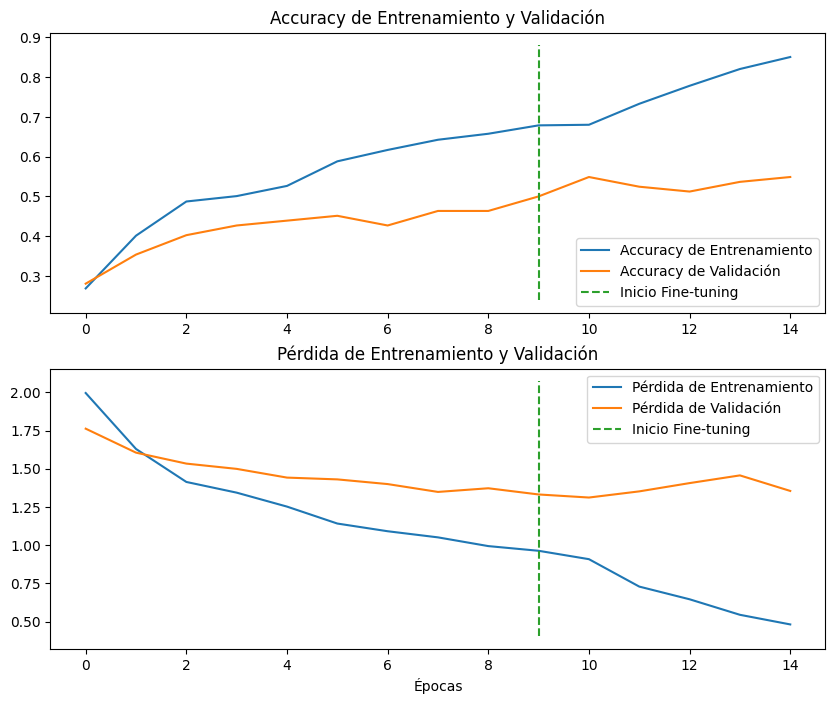

In [31]:
# --- 10. Visualizar el Historial de Entrenamiento ---
def plot_history(history_initial, history_fine_tune):
    acc = history_initial.history["accuracy"] + history_fine_tune.history["accuracy"]
    val_acc = (
        history_initial.history["val_accuracy"]
        + history_fine_tune.history["val_accuracy"]
    )
    loss = history_initial.history["loss"] + history_fine_tune.history["loss"]
    val_loss = (
        history_initial.history["val_loss"] + history_fine_tune.history["val_loss"]
    )

    plt.figure(figsize=(10, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label="Accuracy de Entrenamiento")
    plt.plot(val_acc, label="Accuracy de Validación")
    plt.plot(
        [epochs_initial - 1, epochs_initial - 1],
        plt.ylim(),
        label="Inicio Fine-tuning",
        linestyle="--",
    )
    plt.legend(loc="lower right")
    plt.title("Accuracy de Entrenamiento y Validación")

    plt.subplot(2, 1, 2)
    plt.plot(loss, label="Pérdida de Entrenamiento")
    plt.plot(val_loss, label="Pérdida de Validación")
    plt.plot(
        [epochs_initial - 1, epochs_initial - 1],
        plt.ylim(),
        label="Inicio Fine-tuning",
        linestyle="--",
    )
    plt.legend(loc="upper right")
    plt.title("Pérdida de Entrenamiento y Validación")
    plt.xlabel("Épocas")
    plt.show()


plot_history(history_initial, history_fine_tune)
